# CG for Poisson problem
## Numerical experiments for the conditioning

Consider the Posson problem on $\Omega\subseteq\mathbb R^{d}$, $d=2,3$.

\begin{equation*}
\begin{array}{rclll}
-\Delta u &=& f&\mbox{in}&\Omega \\
u &=& u_D& \mbox{on}& \partial \Omega
\end{array}
\end{equation*}

In [1]:
from ngsolve import *
from netgen.geom2d import unit_square 
from ngsolve.webgui import Draw 
from ngsolve.la import EigenValues_Preconditioner
import scipy.sparse as sp
from scipy.sparse.linalg import eigs, eigsh, norm
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3)
import pandas as pd

In [29]:
def bilinearform_to_scipy(a):
    # sparse scipy matrix
    rows,cols,vals = a.mat.COO()
    A = sp.csr_matrix((vals,(rows,cols)))
    return A

def testCG_full_condensed(mesh, p,db):
    afull, fes = SetUp_CG(mesh, p, db, condense=False)
    Afull = bilinearform_to_scipy(afull)

    acondensed, fes = SetUp_CG(mesh, p, db, condense=True)
    Acondensed = bilinearform_to_scipy(acondensed)

    fig,ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].spy(Afull)
    ax[1].spy(Acondensed)
    plt.show()

#     fd = list(fes.FreeDofs(coupling=True))
    fd = np.nonzero(fes.FreeDofs(coupling=True))[0]
    print(fd)
    Afullfree = Afull[fd,:][:,fd]
    Acondensedfree = Acondensed[fd,:][:,fd]
    print("Afull:", Afullfree)
    print("Afull:", Acondensedfree)
    print("||Afull-Acondensed|| = ", norm(Afullfree-Acondensedfree, 'fro'))


def SetUp_CG(mesh,p, db, condense=False):
    fes = H1(mesh, order=p, dirichlet=db)
    u, v = fes.TnT()
    # Bilinear form
    a = BilinearForm(fes, condense=condense)
    a += (grad(u)*grad(v))*dx
    a.Assemble();
    return a, fes

def SolvePoisson_CG(mesh, p, force, uD, db, condense): # Dirichlet boundary conditions
    a, fes = SetUp_CG(mesh, p, db, condense)
    v = fes.TestFunction()
    f = LinearForm(fes)
    f += (force*v)*dx
    f.Assemble()
    gf = GridFunction(fes)
    gf.Set(uD, BND)
    if condense:
        gf.vec.data += a.harmonic_extension * gf.vec
        invS = a.mat.Inverse(freedofs=fes.FreeDofs(coupling=True))
        ext = IdentityMatrix() + a.harmonic_extension
        extT = IdentityMatrix() + a.harmonic_extension_trans
        invA =  ext @ invS @ extT + a.inner_solve
        print("condensed system, N dof:", fes.ndof)
        print("dof:", sum(list(fes.FreeDofs(coupling=True))) )
    else:
        invA = a.mat.Inverse(freedofs=fes.FreeDofs(coupling=False))
        print("full system, N dof:", fes.ndof)
        print("dof:", sum(list(fes.FreeDofs(coupling=False))))
        
    gf.vec.data += invA * (f.vec - a.mat*gf.vec)
    
    return gf

In [30]:
def get_kappa(mesh,p, db, condense):
    a, fes=SetUp_CG(mesh, p, db, condense)

    # size of non condensed=full system
    n_fs = sum(list(fes.FreeDofs(coupling=False)))
    n_cs = sum(list(fes.FreeDofs(coupling=True)))
    # sparse scipy matrix
    rows,cols,vals = a.mat.COO()
    A = sp.csr_matrix((vals,(rows,cols)))
    
    # restrict to freedof
    plt.spy(A,precision=1e-12)
    plt.show()
    fd = list(fes.FreeDofs(condense))
    print(A)
    Afree = A[fd,:][:,fd]
    print(Afree)
    print(fd)
    plt.spy(Afree,precision=1e-12)
    plt.show()
    print(n_fs, n_cs, Afree.shape)
    # Estimate condition number kappa
    lams_LM = eigsh(Afree, which='LM', tol=1e-8)[0]
    lams_SM = eigsh(Afree, which='SM', tol=1e-8,maxiter=10**5)[0]
    lams = np.concatenate((lams_LM, lams_SM))
    print(p, lams)
    kappa = max(lams)/min(lams)
    return kappa

In [31]:
def test_condition_number_fixmesh(mesh, db, condense=False, pmax=6):
    kappa=[]
    p = [i for i in range(3,pmax+1)]
    for pi in p:
        kappa.append(get_kappa(mesh, pi, db, condense))
    return p, kappa

# Two-dimensional problem

In [32]:
# Data
force2d = ((2*pi**2))*sin(pi*x)*sin(pi*y)
uD    = 0        
dirichlet_boundary2d = 'left|bottom|right|top'

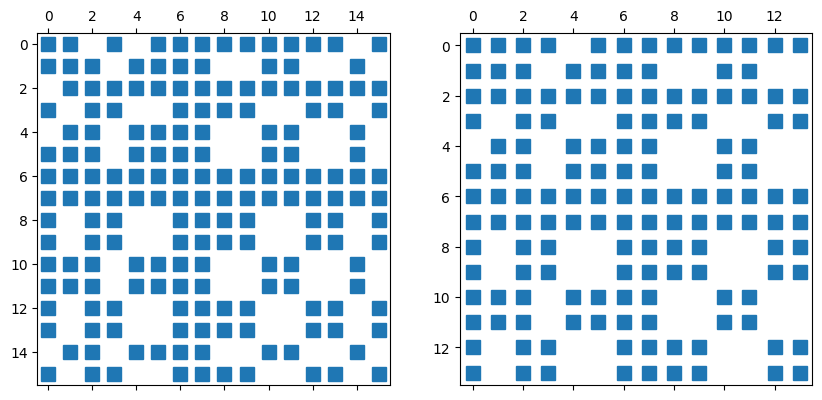

[6 7]
Afull:   (0, 0)	0.08333333333333312
  (0, 1)	-3.5128150388530344e-17
  (1, 0)	-3.5128150388530344e-17
  (1, 1)	0.022222222222222227
Afull:   (0, 0)	0.08333333333333312
  (0, 1)	-3.512815038853032e-17
  (1, 0)	-3.512815038853032e-17
  (1, 1)	0.022222222222222227
||Afull-Acondensed|| =  3.486305596842099e-32


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [33]:
# Fix h
h = 1.0
mesh2d = Mesh(unit_square.GenerateMesh(maxh=h))

testCG_full_condensed(mesh2d, p=3, db=dirichlet_boundary2d)
Draw(mesh2d)

In [60]:
gfu = SolvePoisson_CG(mesh2d, p=3, force=force2d, uD=uD, db=dirichlet_boundary2d, condense=False)
Draw(gfu)

full system, N dof: 16
dof: 4


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.22…

BaseWebGuiScene

## Condition number - Two-dimensional case

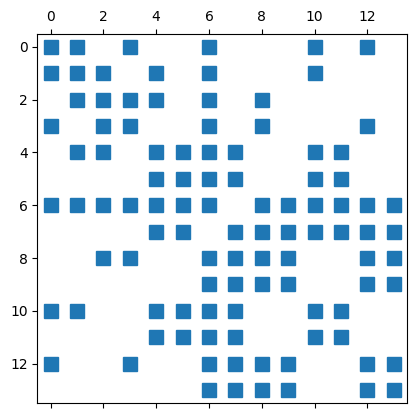

  (0, 0)	0.08333333333333312
  (0, 1)	-3.512815038853032e-17
  (1, 0)	-3.512815038853032e-17
  (1, 1)	0.022222222222222227
[False, False, False, False, False, False, True, True, False, False, False, False, False, False, False, False]


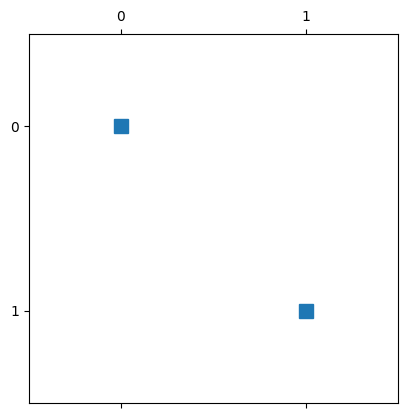

4 2 (2, 2)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1590: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


TypeError: Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.

In [31]:
# p, kappa= test_condition_number_fixmesh(mesh,dirichlet_boundary,condense=False, pmax=10)
p_sc_2d, kappa_sc_2d = test_condition_number_fixmesh(mesh2d, dirichlet_boundary2d, condense=True, pmax=3)

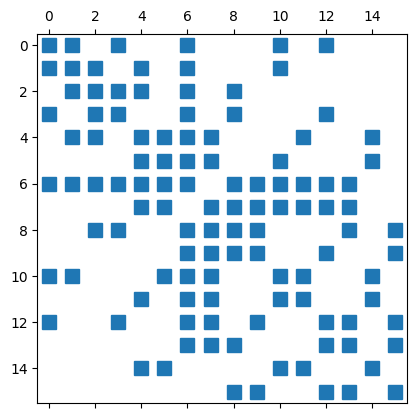

  (0, 0)	0.08333333333333312
  (0, 1)	-3.5128150388530344e-17
  (0, 2)	-1.734723475976807e-17
  (0, 3)	3.5561831257524545e-17
  (1, 0)	-3.5128150388530344e-17
  (1, 1)	0.022222222222222227
  (1, 2)	1.6371452804531117e-17
  (1, 3)	-2.168404344971009e-19
  (2, 0)	-1.734723475976807e-17
  (2, 1)	1.6371452804531117e-17
  (2, 2)	0.01111111111111107
  (3, 0)	3.5561831257524545e-17
  (3, 1)	-2.168404344971009e-19
  (3, 3)	0.01111111111111108
[False, False, False, False, False, False, True, True, False, False, False, False, False, False, True, True]


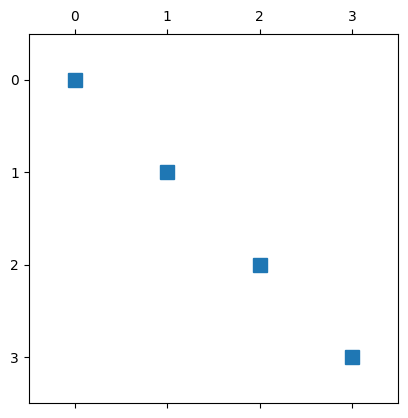

4 2 (4, 4)


TypeError: Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.

In [32]:
p_sc_2d, kappa_sc_2d = test_condition_number_fixmesh(mesh2d, dirichlet_boundary2d, condense=False, pmax=3)

In [133]:
def plots_cond_number(p, kappa):
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.semilogx(p, kappa,'--o',label='kappa')
    
    C2 = kappa[0]/(np.log(p[0])*np.log(p[0]))
    p2 = [C2*np.log(p_i)*np.log(p_i) for p_i in p]
    ax.semilogx(p, p2,'C02', label='log(p)^2')

    C3 = kappa[0]/(np.log(p[0])*np.log(p[0])*np.log(p[0]))
    p3 = [C3*np.log(p_i)*np.log(p_i)*np.log(p_i) for p_i in p]
    ax.semilogx(p, p3,'C03', label='log(p)^3')
    ax.legend()
#     plt.savefig('kappa_HDG_2d.png')
    plt.show()
def compute_gamma(kappa, p):
    gamma = [0.0]
    for i in range(len(p)-1):
        gamma.append(np.log(kappa[i+1]/kappa[i])/np.log(np.log(p[i+1])/np.log(p[i])))
    return gamma
def compute_alpha(kappa, p):
    # Adjust \kappa = O(p^\alpha)
    alpha = [0.0]
    for i in range(len(p)-1):
        alpha.append(np.log(kappa[i+1]/kappa[i])/np.log((p[i+1])/(p[i])))
    return alpha


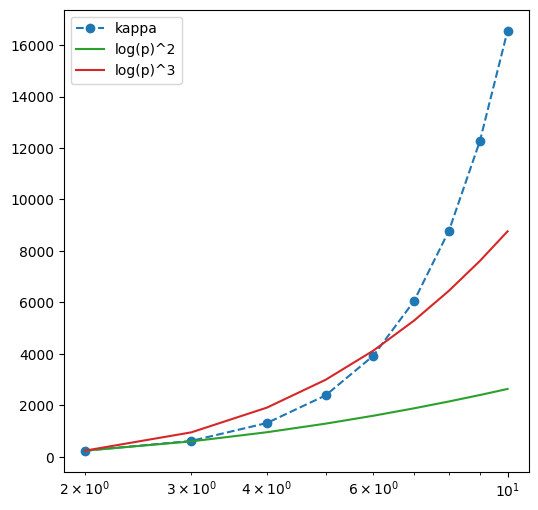

In [134]:
gamma2d = compute_gamma(kappa_sc_2d, p_sc_2d)
alpha2d = compute_alpha(kappa_sc_2d, p_sc_2d)
df_2d = pd.DataFrame({'p':p_sc_2d, 'kappa':kappa_sc_2d, 'log(p)':np.log(p_sc_2d), 'gamma':gamma2d, 'alpha':alpha2d})
# print(gamma2d)
plots_cond_number(p_sc_2d, kappa_sc_2d)

In [135]:
df_2d


,p,kappa,log(p),gamma,alpha
0,2,239.049449,0.693147,0.000000,0.000000
1,3,618.847957,1.098612,2.065285,2.345921
2,4,1314.233560,1.386294,3.238148,2.617992
3,5,2385.260209,1.609438,3.993646,2.671171
4,6,3931.815471,1.791759,4.657336,2.741272
5,7,6044.727961,1.945910,5.211150,2.790031
6,8,8788.864316,2.079442,5.639619,2.803079
7,9,12273.415123,2.197225,6.061279,2.835298
8,10,16560.203612,2.302585,6.395886,2.843256


# 3D case

In [44]:
from netgen.csg import *

In [45]:
# Data
force3d = ((3*pi**2))*sin(pi*x)*sin(pi*y)*sin(pi*z)
uD    = 0        
dirichlet_boundary3d = 'back|left|front|right|bottom|top'

In [46]:
# Fix h
h = 0.5
mesh3d = Mesh(unit_cube.GenerateMesh(maxh=h))
# print(mesh.GetBoundaries())
# Draw(mesh)

In [47]:
gfu = SolvePoisson_CG(mesh3d, p=5,force=force3d, uD=uD, db=dirichlet_boundary3d)
# Draw(gfu)

In [48]:
p_sc_3d, kappa_sc_3d = test_condition_number_fixmesh(mesh3d, dirichlet_boundary3d, condense=True, pmax=10)

2 [1.763 1.869 2.213 2.703 3.03  3.599 0.005 0.006 0.006 0.007 0.008 0.008]
3 [1.763e+00 1.870e+00 2.214e+00 2.704e+00 3.031e+00 3.600e+00 3.001e-04
 4.465e-04 4.538e-04 4.703e-04 4.847e-04 5.086e-04]
4 [1.763e+00 1.870e+00 2.214e+00 2.704e+00 3.031e+00 3.600e+00 8.226e-05
 1.110e-04 1.152e-04 1.211e-04 1.296e-04 1.391e-04]
5 [1.763e+00 1.870e+00 2.214e+00 2.704e+00 3.031e+00 3.600e+00 2.870e-05
 3.519e-05 3.679e-05 3.996e-05 4.171e-05 4.435e-05]
6 [1.763e+00 1.870e+00 2.214e+00 2.704e+00 3.031e+00 3.600e+00 1.089e-05
 1.356e-05 1.393e-05 1.546e-05 1.617e-05 1.712e-05]
7 [1.763e+00 1.870e+00 2.214e+00 2.704e+00 3.031e+00 3.600e+00 4.775e-06
 5.956e-06 6.046e-06 6.769e-06 7.083e-06 7.503e-06]
8 [1.763e+00 1.870e+00 2.214e+00 2.704e+00 3.031e+00 3.600e+00 2.335e-06
 2.884e-06 2.906e-06 3.276e-06 3.424e-06 3.616e-06]
9 [1.763e+00 1.870e+00 2.214e+00 2.704e+00 3.031e+00 3.600e+00 1.243e-06
 1.512e-06 1.515e-06 1.713e-06 1.788e-06 1.884e-06]
10 [1.763e+00 1.870e+00 2.214e+00 2.704e+00 3.031

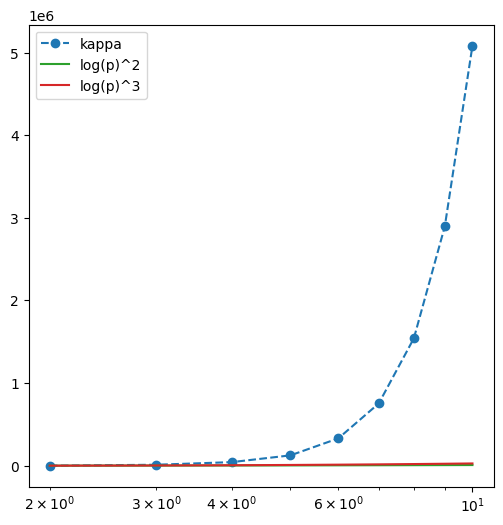

,p,kappa,log(p),gamma,alpha
0,2,7.570305e+02,0.693147,0.000000,0.000000
1,3,1.199561e+04,1.098612,5.998975,6.814131
2,4,4.376396e+04,1.386294,5.564685,4.498960
3,5,1.254527e+05,1.609438,7.056036,4.719467
4,6,3.307176e+05,1.791759,9.032781,5.316627
5,7,7.539209e+05,1.945910,9.984313,5.345566
6,8,1.541624e+06,2.079442,10.777598,5.356826
7,9,2.895130e+06,2.197225,11.438170,5.350459
8,10,5.083073e+06,2.302585,12.017867,5.342477


In [49]:
gamma3d = compute_gamma(kappa_sc_3d, p_sc_3d)
alpha3d = compute_alpha(kappa_sc_3d, p_sc_3d)
df_3d = pd.DataFrame({'p':p_sc_3d, 'kappa':kappa_sc_3d, 'log(p)':np.log(p_sc_3d), 'gamma':gamma3d, 'alpha':alpha3d})
plots_cond_number(p_sc_3d, kappa_sc_3d)

df_3d

In [50]:
# !pip install tabulate
from tabulate import tabulate

def dataframe_to_latex(df, filename=None, col_round=None):
    """
    Print and save a DataFrame as a LaTeX table.

    Parameters:
    df (pd.DataFrame): The DataFrame to convert.
    filename (str): The name of the file to save the LaTeX table to.
    """
    
    if col_round is not None:
        df_rounded = df.copy()
        
        for columns, precision in col_round:
            df_rounded[columns]
            print(columns, precision)
            df_rounded[columns] = df_rounded[columns].round(precision)
    # Convert DataFrame to LaTeX table string
    latex_table = tabulate(df_rounded, headers='keys', tablefmt='latex', showindex=False)

    # Print the LaTeX table
    print(latex_table)

    # Save the LaTeX table to a file
    if filename is not None:
        with open(filename, 'w') as f:
            f.write(latex_table)

    

In [51]:
dataframe_to_latex(df_2d,filename='table_CG2d_kappa', col_round=[['kappa',1],['log(p)', 3],['gamma',3],['alpha',3]])
dataframe_to_latex(df_3d,filename='table_CG3d_kappa', col_round=[['kappa',1],['log(p)', 3],['gamma',3],['alpha',3]])

kappa 1
log(p) 3
gamma 3
alpha 3
\begin{tabular}{rrrrr}
\hline
   p &    kappa &   log(p) &   gamma &   alpha \\
\hline
   2 &    239   &    0.693 &   0     &   0     \\
   3 &    618.8 &    1.099 &   2.065 &   2.346 \\
   4 &   1314.2 &    1.386 &   3.238 &   2.618 \\
   5 &   2385.3 &    1.609 &   3.994 &   2.671 \\
   6 &   3931.8 &    1.792 &   4.657 &   2.741 \\
   7 &   6044.7 &    1.946 &   5.211 &   2.79  \\
   8 &   8788.9 &    2.079 &   5.64  &   2.803 \\
   9 &  12273.4 &    2.197 &   6.061 &   2.835 \\
  10 &  16560.2 &    2.303 &   6.396 &   2.843 \\
  11 &  21756.6 &    2.398 &   6.729 &   2.863 \\
  12 &  27928.9 &    2.485 &   7.007 &   2.87  \\
  13 &  35179.7 &    2.565 &   7.28  &   2.884 \\
  14 &  43579.9 &    2.639 &   7.518 &   2.889 \\
  15 &  53228.1 &    2.708 &   7.749 &   2.899 \\
  16 &  64198.5 &    2.773 &   7.956 &   2.904 \\
  17 &  76586.8 &    2.833 &   8.157 &   2.91  \\
  18 &  90469.8 &    2.89  &   8.341 &   2.915 \\
  19 & 105941   &    2.944 &  

In [172]:
help(BilinearForm)

Help on class BilinearForm in module ngsolve.comp:

class BilinearForm(NGS_Object)
 |  Used to store the left hand side of a PDE. integrators (ngsolve.BFI)
 |  to it to implement your PDE. If the left hand side is linear
 |  you can use BilinearForm.Assemble to assemble it after adding
 |  your integrators. For nonlinear usage use BilinearForm.Apply or
 |  BilinearForm.AssembleLinearization instead of Bilinearform.Assemble.
 |  
 |  Parameters:
 |  
 |  space : ngsolve.FESpace
 |    The finite element space the bilinearform is defined on. This
 |    can be a compound FESpace for a mixed formulation.
 |  
 |  
 |   Keyword arguments can be:
 |  condense: bool = False
 |    (formerly known as 'eliminate_internal')
 |    Set up BilinearForm for static condensation of internal
 |    bubbles. Static condensation has to be done by user,
 |    this enables only the use of the members harmonic_extension,
 |    harmonic_extension_trans and inner_solve. Have a look at the
 |    documentation for

In [95]:
help(H1)

Help on class H1 in module ngsolve.comp:

class H1(FESpace)
 |  An H1-conforming finite element space.
 |  
 |  The H1 finite element space consists of continuous and
 |  element-wise polynomial functions. It uses a hierarchical (=modal)
 |  basis built from integrated Legendre polynomials on tensor-product elements,
 |  and Jaboci polynomials on simplicial elements. 
 |  
 |  Boundary values are well defined. The function can be used directly on the
 |  boundary, using the trace operator is optional.
 |  
 |  The H1 space supports variable order, which can be set individually for edges, 
 |  faces and cells. 
 |  
 |  Internal degrees of freedom are declared as local dofs and are eliminated 
 |  if static condensation is on.
 |  
 |  The wirebasket consists of all vertex dofs. Optionally, one can include the 
 |  first (the quadratic bubble) edge basis function, or all edge basis functions
 |  into the wirebasket.
 |  
 |  Keyword arguments can be:
 |  
 |  order: int = 1
 |    order 

In [96]:
help(L2)

Help on class L2 in module ngsolve.comp:

class L2(FESpace)
 |  An L2-conforming finite element space.
 |  
 |  The L2 finite element space consists of element-wise polynomials,
 |  which are discontinuous from element to element. It uses an
 |  L2-orthogonal hierarchical basis which leads to orthogonal
 |  mass-matrices on non-curved elements.
 |  
 |  Boundary values are not meaningful for an L2 function space.
 |  
 |  The L2 space supports element-wise variable order, which can be set
 |  for ELEMENT-nodes.
 |  
 |  Per default, all dofs are local dofs and are condensed if static
 |  condensation is performed. The lowest order can be kept in the
 |  WIRE_BASKET via the flag 'lowest_order_wb=True'.
 |  
 |  All dofs can be hidden. Then the basis functions don't show up in the
 |  global system.
 |  
 |  Keyword arguments can be:
 |  
 |  order: int = 1
 |    order of finite element space
 |  complex: bool = False
 |    Set if FESpace should be complex
 |  dirichlet: regexpr
 |    Re